# Use case 5: Camera images

In [1]:
import showermodel as sm
import numpy as np
import matplotlib.pyplot as plt

`ShowerModel` allows you to generate camera images and temporal sequences by means of the class `Image`. This notebook describes the properties and methods of this class.

### Construction of an `Image` object

An `Image` object is generated from a `Signal` object, which is in turn constructed from a `Shower` object and a `Telescope` object (see UC3). It contains a temporal sequence of images of the shower viewed by the telescope, which is obtained in two steps. First, the total transit time of the shower in the telescope field of view is divided into several frames, each one corresponding to a time interval equal to the integration time `int_time`. Second, the signal contribution from each shower discretization step is distributed among the `N_pix` pixels of the telescope camera to make an image.

Both `Shower` and `Signal` only have information on the 1D longitudinal profile of the shower. Nevertheless, `Image` spreads the signal according to the Nishimura-Kamata-Greisen (NKG) lateral profile. This is performed by generating random points within a cylinder of one Molière radius around each longitudinal step of the shower, where the number of points is chosen according to the pixel size. Then the signal from each longitudinal step is distributed among these points following the NKG profile and the average number of photoelectrons produced in each pixel and frame is evaluated. For simplicity, it is assumed that the camera has a circular shape with square pixels and that the spread point function is a delta function.

The image noise is also simulated. This is introduced in terms of the night sky background `NSB` expressed in number of photoelectrons per unit time per unit detection area per unit solid angle, although it may include electronic noise. The corresponding number of photoelectrons produced in each pixel and frame is randomly generated from a Poisson distribution.

The input parameters of `Image` are:

- `signal` : `Signal` object to be used.
- `lat_profile` : Use a NKG lateral profile to spread the signal. If False, a linear shower is assumed. Default True.
- `N_pix` : Number of camera pixels. If not given, the value defined in the `Telescope` object is used. Default None.
- `int_time` : Integration time in microseconds of a camera frame. If not given, the value defined in the `Telescope` object is used. Default None.    
- `NSB` : Night sky background in MHz/m^2/deg^2 (photoelectrons). Default 40.

In [2]:
shower = sm.Shower(x0=0.2, y0=0.1, theta=20., az=45., N_steps=2000)  # More discretization steps to avoid gaps in the image
telescope = sm.Telescope(tel_type='IACT', theta=22., az= 44.)  # Placed at the origin of coordinates
signal = sm.Signal(telescope, shower)
print("Number of pixels of an IACT:", telescope.N_pix)
print("Integration time in us of an IACT:", telescope.int_time)

# Default Image object using N_pix and int_time from telescope
image1 = sm.Image(signal)

# Setting a different N_pix and int_time. NSB is also modified
image2 = sm.Image(signal, N_pix=100, int_time=0.02, NSB=10.)

# The same as image1, but deactivating the signal spread
image3 = sm.Image(signal, lat_profile=False)

Number of pixels of an IACT: 1800
Integration time in us of an IACT: 0.01


The sequence of images (without noise) is stored in the attribute `frames`, which is an object of type `ndarray` of dimensions (`N_frames`, 2x`N_pix_r`+1, 2x`N_pix_r`+1). Time increases along the axis 0, which goes from 0 to `N_frames-1`. The other two axes give the pixel coordinates in the camera frame: axis 1 goes from top to botton and axis 2 goes from left to right relative to the telescope field of view. As a circular camera is assumed, `N_pix_r` needs to be large enough for the matrix to contain the `N_pix` pixels, that is, `N_pix_r` is at least the number of pixel across a camera radius. Matrix elements outside the circular camera are set to $-\infty$ ("blanck pixels").

In this example, the number of pixels having a signal greater than 1 photoelectron on average is calculated for the above-defined `Image` objects. Note that image3 has the same number of pixles as image1, but the number of pixels with signal is much smaller because the signal spreading is deactivated.

In [3]:
print("# image1: 1800 pixels")
sum1 = image1.frames.sum(0)  # Sum of frames
n1 = len(sum1[sum1>1.].flat)  # Number of pixels with signal
print("Number of pixels with >1pe:", n1)

print("\n")
print("# image2: 100 pixels")
sum2 = image2.frames.sum(0)  # Sum of frames
n2 = len(sum2[sum2>1.].flat)
print("Number of pixels with >1pe:", n2)

print("\n")
print("# image3: 1800 pixels but signal spreading deactivated")
sum3 = image3.frames.sum(0)  # Sum of frames
n3 = len(sum3[sum3>1.].flat)
print("Number of pixels with >1pe:", n3)

# image1: 1800 pixels
Number of pixels with >1pe: 427


# image2: 100 pixels
Number of pixels with >1pe: 41


# image3: 1800 pixels but signal spreading deactivated
Number of pixels with >1pe: 38


`Image` has some other attributes containing characteristics of the camera frame, the pixels and the night sky background. The example below illustrates that the noise level per pixel and frame is much higher in image2, because the camera has less pixels and lower integration time.

In [4]:
print("# image1")
print("Number of pixels:", image1.N_pix)
print("Number of pixels across a camera radius:", image1.N_pix_r)
print("Integration time in microseconds:", image1.int_time)
print("Dimensions of frames:", image1.frames.shape)
print("NSB in MHz/m^2/deg^2:", image1.NSB)
print("Mean number of background photoelectrons per pixel and frame:", np.around(image1.NSB_pix, 3))

print("\n")
print("# image2")
print("Number of pixels:", image2.N_pix)
print("Number of pixels across a camera radius:", image2.N_pix_r)
print("Integration time in microseconds:", image2.int_time)
print("Dimensions of frames:", image2.frames.shape)
print("NSB in MHz/m^2/deg^2:", image2.NSB)
print("Mean number of background photoelectrons per pixel and frame:", np.around(image2.NSB_pix, 3))

# image1
Number of pixels: 1800
Number of pixels across a camera radius: 24
Integration time in microseconds: 0.01
Dimensions of frames: (4, 49, 49)
NSB in MHz/m^2/deg^2: 40.0
Mean number of background photoelectrons per pixel and frame: 1.263


# image2
Number of pixels: 100
Number of pixels across a camera radius: 6
Integration time in microseconds: 0.02
Dimensions of frames: (2, 13, 13)
NSB in MHz/m^2/deg^2: 10.0
Mean number of background photoelectrons per pixel and frame: 11.365


Help on `Image`.

In [5]:
# sm.Image?

### Image visualization

`Image` has the method `show` to visualize the camera image in a color map. By default, the sum of frames is shown and the image includes the night sky background, which is randomly generated in each pixel from a Poisson distribution with mean `NSB_pix * N_frames`. However, you can select a specific frame via the parameter `frame` (from 0 to `N_frames`-1) and change the value of `NSB` to generate the image. `show` returns an object of type `AxesSubplot` so that you can do changes in the plot.

In the example below, a high-resolution (3000 pixels) image of a shower is generated with the default NSB level. Then, the last frame is shown setting `NSB=0`. Otherwise the frame would be dominated by noise.

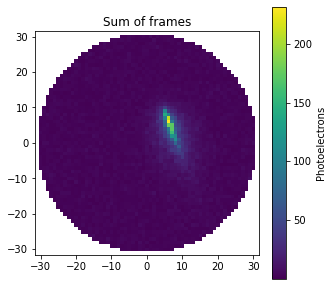

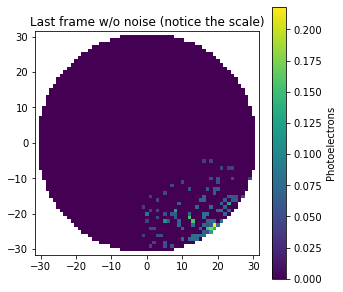

In [6]:
image4 = sm.Image(signal, N_pix=3000, int_time=0.002)

# Default visualization
ax1 = image4.show();
ax1.set_title("Sum of frames");

# Selecting a specific frame and setting NSB to 0
last_frame = image4.N_frames - 1
ax2 = image4.show(frame=last_frame, NSB=0.);
ax2.set_title("Last frame w/o noise (notice the scale)");

# If NSB takes the default value, the last frame woult be dominated by noise
#ax3 = image4.show(frame=last_frame);
#ax3.set_title("Last frame w/ noise");

These camera images are not shown in the `theta`/`phi` projection used by the method `show_projection`. Instead, a projection that keeps the pixel area constant is used. The axis labels represent the number of pixels across the vertical and horizontal directions relative to the telescope field of view, where (0, 0) corresponds to the central pixel of the camera. Although `Image` and `show_projection` use different projections, the distortion is only noticeable at large offset angle. Below is an example of a distant shower observed transversely by a fluorescence telescope with a large aperture of 40$^\circ$ (see also UC3).

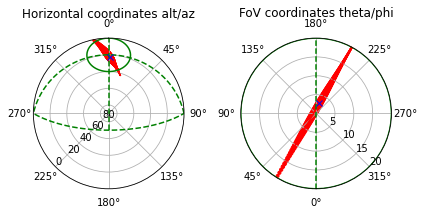

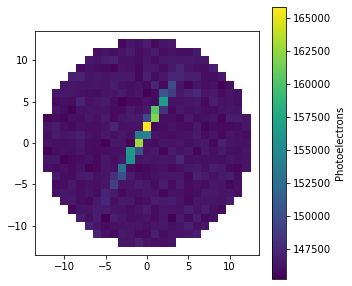

In [7]:
# 1 EeV hadronic shower with impact point at 12 km North
shower = sm.Shower(E=1.e12, prf_model='Gaisser-Hillas', X_max=500., x0=-2.5, y0=12., theta=45., az=20.)
# The telescope aperture is 40 degrees and it is pointing just above the horizon
# Fluorescence telescopes have less pixels and greater integration time than an IACT
telescope = sm.Telescope(tel_type='IACT', alt=20., az=0., apert=40., N_pix=500, int_time=1.)
signal_fluo = sm.Signal(shower, telescope)
image_fluo = sm.Image(signal_fluo)

signal_fluo.show_projection(max_theta=20.); # FoV plot only shows the FoV
image_fluo.show();

`Image` has also the method `animate` to generate a video of the camera frames. This method also allows you to modify both `N_pix` and `NSB`. Below is shown the sequence of camera frames of the object image4, where `N_pix=3000` and `int_time=0.002`. The smaller `int_time`, more frames in the sequence. Note, however, that the time resolution is limited by the discretization steps of the shower. A too small `int_time` may cause video flickering.

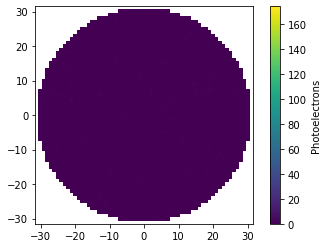

In [8]:
# N_pix=3000, int_time=0.002
image4.animate()  # Default NSB value

# Very high NSB
# image4.animate(NSB=10000.)

# Shower observed by a fluorescence telescope
# image_fluo.animate()

Help on the `show` and `animage` methods of `Image`.

In [9]:
#image.show?
#image.animate?

### Figures with several camera images

`ShowerModel` also allows you to produce figures with several subplots, each one with a different camera image (e.g., for different telescopes and/or different showers). To do that, construct a figure using `subplots` from `matplotlib.pyplot` and pass the generated `AxesSubplot` objects to the `show` method of `Image` via the parameter `ax`, as illustrated in the example below, where the image of a shower is shown for different telesope pointings. The last plot is empty because the shower track is outside the telescope field of view.

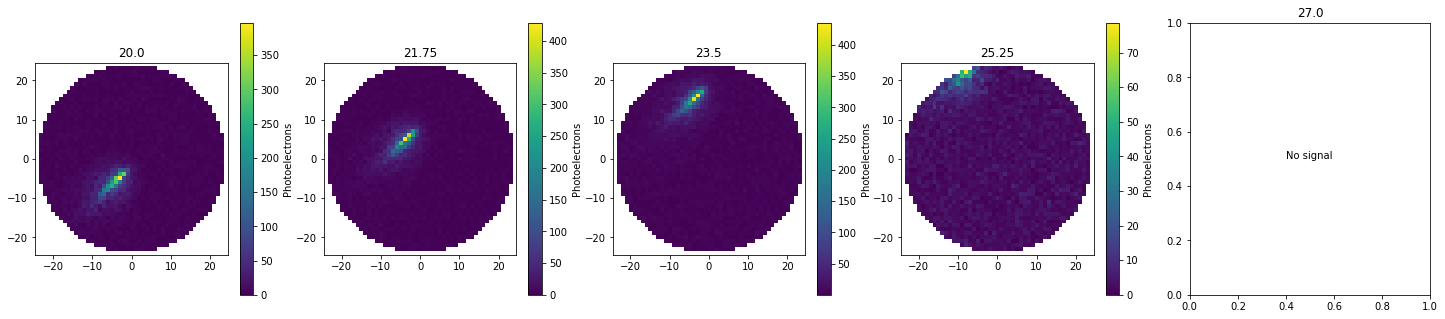

In [10]:
telescope = sm.Telescope(tel_type='IACT', theta=20., az= 44.)
shower = sm.Shower(y0=0.2, theta=20., az=45.)
# 5 plots in a row
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

theta = np.linspace(20., 27., 5)
for th, ax in zip(theta, axes):
    telescope.theta = th  # Only theta is changed
    signal = sm.Signal(telescope, shower)
    image = sm.Image(signal)
    image.show(ax=ax)
    ax.set_title(th)

In addition, there are two special methods of `Event` that also do this type of subplot figures. First, the `make_images` method generates a list of `Image` objects, one for each telescope of the observatory, which is stored as a new attribute named `images` of the `Event` object. This method has also the input parameters `lat_profile` and `NSB`, but not `N_pix` nor `int_time`, because it takes the number of pixels and integration time from the telescopes of the `Event` object. Second, the `show_images` method generates the corresponding subplot figure, where the telescope index is indicated in the title of each plot. This method has no input parameter. Below is an example to generate the 25 camera images using an `Event` object constructed from an `Array25` object.

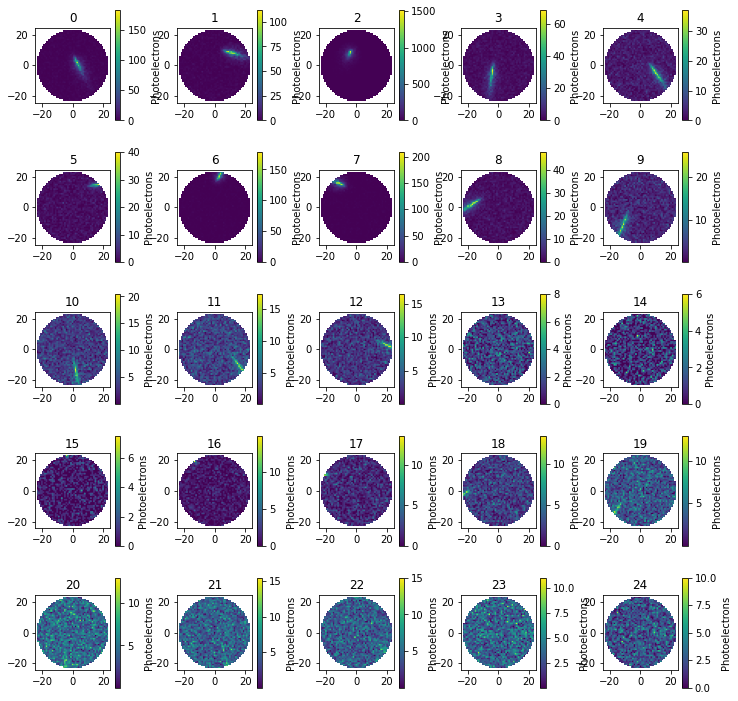

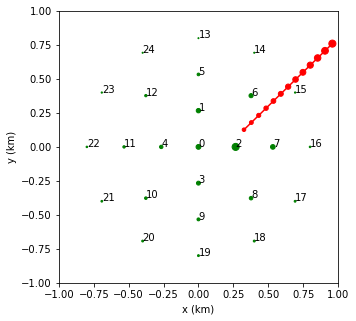

In [11]:
shower = sm.Shower(x0=0.3, y0=0.1, theta=20., az=45.)
observatory = sm.Array25(R=0.8, theta=22., az= 46.)
event = sm.Event(observatory, shower)
event.make_images(NSB=10.)
event.show_images();

# Show the observatory layout below to identify the telescopes
event.show_geometry2D(tel_index=True);